In [79]:
%matplotlib inline

In [6]:
import grid_sim_linear_program as gslp
import grid_sim_simple_example as gsse
import os.path as osp
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load profiles from California.  Profiles are for demand and non-dispatchable sources.

In [7]:
profiles_path = gsse.get_data_directory() + ['profiles', 'profiles_california.csv']
profiles_file = osp.join(*profiles_path)
profiles = pd.read_csv(profiles_file, index_col=0, parse_dates=True)
profiles.columns

Index(['DEMAND', 'SOLAR', 'WIND', 'COAL', 'COAL_CRYO', 'COAL_AMINE',
       'NUCLEAR'],
      dtype='object')

# Setup a Linear Program (LP) with DEMAND

In [8]:
lp = gslp.LinearProgramContainer(profiles)
lp.add_demands(gslp.GridDemand('DEMAND'))

In [16]:
fuel_cost = 5

In [17]:
# Add dispatchable resources, which can arbitrarily match demand.
lp.add_dispatchable_sources(
    gslp.GridSource(
          name='NGCC',  # Dispatchable, so no name restriction.                                                                                                
          nameplate_unit_cost=1239031,  # Cost for a combined cycle plant. $/MW                                                                              
          variable_unit_cost=1.99+(6.20*fuel_cost),  # Cheap fuel costs assumes fracking. $/MWh                                                                               
          co2_per_electrical_energy=0.33,  # Tonnes CO2 / MWh                                                                                                
          is_rps_source=False),
    gslp.GridSource(
          name='NGCT',  # Dispatchable, so no name restriction.                                                                                                
          nameplate_unit_cost=770633.274099,  # Cost for a combined cycle plant. $/MW                                                                              
          variable_unit_cost=10.64+(8.55*fuel_cost),  # Cheap fuel costs assumes fracking. $/MWh                                                                               
          co2_per_electrical_energy=0.453751127329,  # Tonnes CO2 / MWh                                                                                                
          is_rps_source=False),
    gslp.GridSource(
              name='HYDRO',  # Dispatchable, so no name restriction.                                                                                                
              nameplate_unit_cost=217839.46,  # Cost for a combined cycle plant. $/MW                                                                              
              variable_unit_cost=2.66,# Cheap fuel costs assumes fracking. $/MWh  
              max_energy = 13808000,
              max_power = 9594.8,
              co2_per_electrical_energy=0,  # Tonnes CO2 / MWh                                                                                                
              is_rps_source=True))  # Not in Renewable Portfolio Standard. )  # Not in Renewable Portfolio Standard.

# Add non-dispatchable resources.
lp.add_nondispatchable_sources(
    gslp.GridSource(
      name='WIND',  # Matches profile column name for nondispatch.                                                                                      
      nameplate_unit_cost=2181532.57887,  # Aggressive wind cost $/MW                                                                                          
      variable_unit_cost=0,  # No fuel cost.                                                                                                             
      co2_per_electrical_energy=0,  # Clean energy.                                                                                                      
      is_rps_source=True),  # In Renewable Portfolio Standard )
    gslp.GridSource(
      name='SOLAR',  # Matches profile column name for nondispatch.                                                                                      
      nameplate_unit_cost=1356035.01731,  # Aggressive wind cost $/MW                                                                                          
      variable_unit_cost=0,  # No fuel cost.                                                                                                             
      co2_per_electrical_energy=0,  # Clean energy.                                                                                                      
      is_rps_source=True),  # In Renewable Portfolio Standard )
    gslp.GridSource(
      name='NUCLEAR',  # Matches profile column name for nondispatch.                                                                                      
      nameplate_unit_cost=1167257.6816463014+3500000,  # Aggressive wind cost $/MW                                                                                          
      variable_unit_cost=12.0,  # No fuel cost.                                                                                                             
      co2_per_electrical_energy=0,  # Clean energy.                                                                                                      
      is_rps_source=True),  # In Renewable Portfolio Standard )
    gslp.GridSource(
      name='COAL',  # Matches profile column name for nondispatch.                                                                                      
      nameplate_unit_cost=454938.6814+2934000,  # Aggressive wind cost $/MW                                                                                          
      variable_unit_cost=23.302,                                                                                                             
      co2_per_electrical_energy=0.85819676404,                                                                                                      
      is_rps_source=False))

# Also adjust lp based upon what we think future costs are going to be.
hours_per_year = 24 * 365
annual_discount_rate = 0.06
lifetime_in_years = 30

lp.carbon_tax = 0 # No Carbon Tax
lp.rps_percent = 0 # No renewable requirement
lp.cost_of_money = gslp.extrapolate_cost(
  1.0,
  annual_discount_rate,
  lp.number_of_timeslices / hours_per_year,
  lifetime_in_years)

### Calling lp.solve() runs the linear program.  It returns True if the LP converged.

In [18]:
lp.solve()

True

### source_stats(lp) shows statistics about each source in the LP after the LP has converged.

In [19]:
def source_stats(lp):
    index = []
    capital = []
    variable = []
    co2_per_mwh = []
    nameplate = []
    generated = []
    
    for s in lp.sources:
        index.append(s.name)
        capital.append(s.nameplate_unit_cost)
        variable.append(s.variable_unit_cost)
        co2_per_mwh.append(s.co2_per_electrical_energy)
        nameplate.append(s.get_nameplate_solution_value())
        generated.append(sum(s.get_solution_values()))
        
    data = {'capital': capital,
           'variable': variable,
           'co2_per_mwh': co2_per_mwh,
           'nameplate': nameplate,
           'generated': generated}
    
    df = pd.DataFrame(index=index,
                      data=data)
    df['cost_of_money'] = lp.cost_of_money
    df['carbon_tax'] = lp.carbon_tax
    df['total_cost'] = (df.capital * df.nameplate +
                        df.cost_of_money * df.generated *
                        (df.variable + df.co2_per_mwh * df.carbon_tax))
    return df

In [20]:
source_stats(lp)

,capital,variable,co2_per_mwh,nameplate,generated,cost_of_money,carbon_tax,total_cost
NGCC,1.239031e+06,26.790,0.330000,30473.342581,2.547221e+08,14.590721,0,1.373246e+11
NGCT,7.706333e+05,44.840,0.453751,8084.057419,4.464475e+05,14.590721,0,6.521931e+09
HYDRO,2.178395e+05,2.660,0.000000,9594.800000,1.380800e+07,14.590721,0,2.626033e+09
WIND,2.181533e+06,0.000,0.000000,0.000000,0.000000e+00,14.590721,0,0.000000e+00
SOLAR,1.356035e+06,0.000,0.000000,0.000000,0.000000e+00,14.590721,0,0.000000e+00
NUCLEAR,4.667258e+06,12.000,0.000000,0.000000,0.000000e+00,14.590721,0,0.000000e+00
COAL,3.388939e+06,23.302,0.858197,0.000000,0.000000e+00,14.590721,0,0.000000e+00
NGCC,1.239031e+06,32.990,0.330000,0.000000,0.000000e+00,14.590721,0,0.000000e+00
NGCT,7.706333e+05,53.390,0.453751,0.000000,0.000000e+00,14.590721,0,0.000000e+00
HYDRO,2.178395e+05,2.660,0.000000,9594.800000,1.380800e+07,14.590721,0,2.626033e+09


In [24]:
source_stats(lp).nameplate.sum()

57747.0

In [25]:
30473.342581/57747.0

0.5277043410220444

### plot_sources(lp) plots power / time of sources and demand.

In [88]:
def plot_labels(lp):
    plt.xlabel('Hour of Year')
    plt.ylabel('MegaWatts')
    
    title_string = 'Demand and Sources:'
    title_string += 'RPS = %d, Carbon Tax = %d' %(lp.rps_percent,
                                                 lp.carbon_tax)
    plt.title(title_string)
    plt.legend(bbox_to_anchor=(1.25, 1.0))
    
def plot_sources(lp, slicee=None):
    if slicee is None:
        slicee = slice(lp.number_of_timeslices)
    profiles = lp.profiles
    plt.plot(profiles.index[slicee], 
             profiles.DEMAND[slicee], label='Demand')
    for source in lp.sources:
        plt.plot(profiles.index[slicee],
                 source.get_solution_values()[slicee], label=source.name)
    plot_labels(lp)

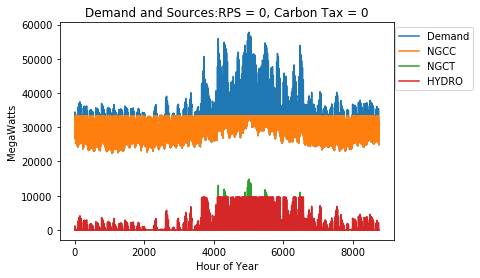

In [90]:
plot_sources(lp)

### Above run is not very interesting because there's only one source so it must match Demand identically

# Add Solar

In [91]:
solar = gslp.GridSource(
      name='SOLAR',  # Matches profile column name for nondispatch.                                                                                      
      nameplate_unit_cost=316035+1040000,  # Aggressive solar cost $/MW                                                                                          
      variable_unit_cost=0,  # No fuel cost.                                                                                                             
      co2_per_electrical_energy=0,  # Clean energy.                                                                                                      
      is_rps_source=True)  # In Renewable Portfolio Standard 

lp.add_nondispatchable_sources(solar)     
lp.solve()

True

In [92]:
source_stats(lp)

,capital,variable,co2_per_mwh,nameplate,generated,cost_of_money,carbon_tax,total_cost
NGCC,1.239031e+06,26.79,0.330000,33294.693947,2.658877e+08,14.590721,0,1.451848e+11
NGCT,7.706333e+05,44.84,0.453751,14857.506053,3.088831e+06,14.590721,0,1.347055e+10
HYDRO,2.178395e+05,2.66,0.000000,9594.800000,1.380800e+07,14.590721,0,2.626033e+09
SOLAR,1.356035e+06,0.00,0.000000,0.000000,0.000000e+00,14.590721,0,0.000000e+00


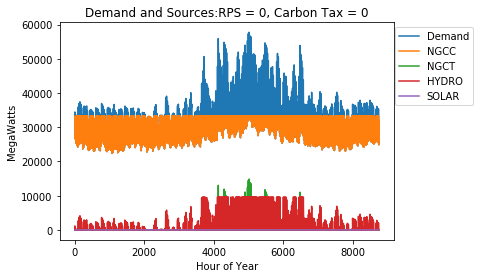

In [93]:
plot_sources(lp)


### Still only Natural Gas (NG) because NG is cheaper than Solar and he LP will generate the cheapest power subject to the constraints.

# Increase Renewable Portfolio Standard (RPS) % which mandates what % comes from renewables.

In [94]:
lp.rps_percent = 30
lp.solve()

True

In [95]:
source_stats(lp)

,capital,variable,co2_per_mwh,nameplate,generated,cost_of_money,carbon_tax,total_cost
NGCC,1.239031e+06,26.79,0.330000,29836.440537,1.948354e+08,14.590721,0,1.131266e+11
NGCT,7.706333e+05,44.84,0.453751,16750.808972,3.113719e+06,14.590721,0,1.494588e+10
HYDRO,2.178395e+05,2.66,0.000000,9594.800000,1.380800e+07,14.590721,0,2.626033e+09
SOLAR,1.356035e+06,0.00,0.000000,29435.971978,7.104316e+07,14.590721,0,3.991621e+10


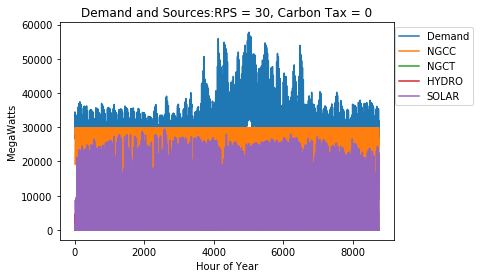

In [96]:
plot_sources(lp)

### Above is lots of data, and a little confusing, so let's slice it down somewhat.
### Here's 200 hours in the middle of the year. (Note hours are UTC)

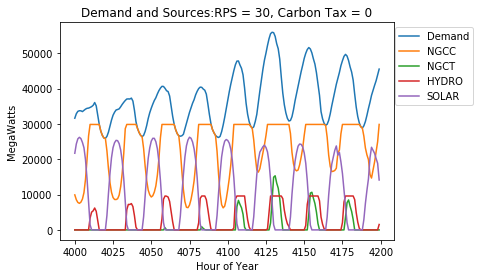

In [97]:
plot_sources(lp,slice(4000,4200))

# Add Wind to see how the LP handles Solar and Wind as RPS

In [98]:
wind = gslp.GridSource(
      name='WIND',  # Matches profile column name for nondispatch.                                                                                      
      nameplate_unit_cost=681532.6+1500000,  # Aggressive wind cost $/MW                                                                                          
      variable_unit_cost=0,  # No fuel cost.                                                                                                             
      co2_per_electrical_energy=0,  # Clean energy.                                                                                                      
      is_rps_source=True)  # In Renewable Portfolio Standard 
lp.add_nondispatchable_sources(wind)
     
lp.solve()

True

In [99]:
source_stats(lp)

,capital,variable,co2_per_mwh,nameplate,generated,cost_of_money,carbon_tax,total_cost
NGCC,1.239031e+06,26.79,0.330000,28246.682438,1.950286e+08,14.590721,0,1.112324e+11
NGCT,7.706333e+05,44.84,0.453751,15553.060806,2.920535e+06,14.590721,0,1.389646e+10
HYDRO,2.178395e+05,2.66,0.000000,9594.800000,1.380800e+07,14.590721,0,2.626033e+09
SOLAR,1.356035e+06,0.00,0.000000,23530.531861,5.679049e+07,14.590721,0,3.190822e+10
WIND,2.181533e+06,0.00,0.000000,4752.625311,1.423686e+07,14.590721,0,1.036801e+10


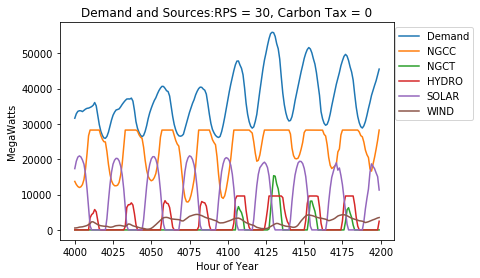

In [100]:
plot_sources(lp,slice(4000,4200))

### Solar is so much cheaper than wind (at a very futuristic price) so that no wind is used.

# Bring Solar Costs Back Somewhat to Present Day.

In [24]:
solar.nameplate_unit_cost = 1.5e6 # $ / Mw
lp.solve()

True

In [25]:
source_stats(lp)

,capital,variable,co2_per_mwh,nameplate,generated,cost_of_money,carbon_tax,total_cost
NG,1239031.0,17.5,0.33,52747.308272,1.979492e+08,14.590721,0,1.158994e+11
SOLAR,1500000.0,0.0,0.00,27522.632468,6.642535e+07,14.590721,0,4.128395e+10
WIND,2051532.0,0.0,0.00,6153.432086,1.843309e+07,14.590721,0,1.262396e+10


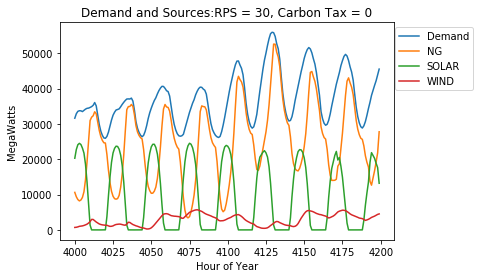

In [26]:
plot_sources(lp,slice(4000,4200))

### Some wind is now showing up.

# Increase rps_percent and Watch the Wind / Solar Distribution.

In [27]:
lp.rps_percent = 60
lp.solve()

True

In [28]:
source_stats(lp)

,capital,variable,co2_per_mwh,nameplate,generated,cost_of_money,carbon_tax,total_cost
NG,1239031.0,17.5,0.33,50512.978848,1.131138e+08,14.590721,0,9.146936e+10
SOLAR,1500000.0,0.0,0.00,25076.268225,6.052110e+07,14.590721,0,3.761440e+10
WIND,2051532.0,0.0,0.00,39540.954484,1.184480e+08,14.590721,0,8.111953e+10


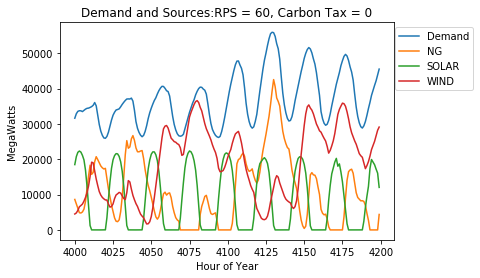

In [29]:
plot_sources(lp,slice(4000,4200))

### Solar Capacity slightly decreased 28GW -> 25GW 
### Wind Capacity surged 6GW -> 40GW

# Add Storage 

In [30]:
# Note: solving takes somewhat more time with storage
storage = gslp.GridRecStorage(
    name='STORAGE',
    storage_nameplate_cost=187000, # $ / Mwh of storage capacity
    charge_nameplate_cost=100000, # $ / Mw of charging capacity
    discharge_nameplate_cost=100000, # $ / Mw of discharging capacity
    charge_efficiency=0.9,
    discharge_efficiency=0.9,
    storage_efficiency=1.0)
lp.add_storage(storage)
lp.solve()

True

In [31]:
source_stats(lp)

,capital,variable,co2_per_mwh,nameplate,generated,cost_of_money,carbon_tax,total_cost
NG,1239031.0,17.5,0.33,37404.827915,1.136840e+08,14.590721,0,7.537354e+10
SOLAR,1500000.0,0.0,0.00,33868.406897,8.174076e+07,14.590721,0,5.080261e+10
WIND,2051532.0,0.0,0.00,31008.855604,9.288944e+07,14.590721,0,6.361566e+10


In [32]:
# Helper function to show cost and usage information for storage.

def storage_stats(lp):
    index = []
    capital_charge = []
    capital_discharge = []
    capital_storage = []
    storage_capacity = []
    charge_capacity = []
    discharge_capacity = []
    
    for s in lp.storage:
        index.append(s.name)
        capital_charge.append(s.charge_nameplate_cost)
        capital_discharge.append(s.discharge_nameplate_cost)
        capital_storage.append(s.storage_nameplate_cost)
        storage_capacity.append(s.energy_nameplate.solution_value())
        charge_capacity.append(s.charge_nameplate.solution_value())
        discharge_capacity.append(s.discharge_nameplate.solution_value())
    df = pd.DataFrame(index=index,
                     data={'capital_charge': capital_charge,
                           'capital_storage': capital_storage,
                           'capital_discharge': capital_discharge,
                           'storage_capacity': storage_capacity,
                           'charge_capacity': charge_capacity,
                           'discharge_capacity': discharge_capacity
                           })
    df['total_cost'] = (df.capital_storage * df.storage_capacity +
                        df.capital_charge * df.charge_capacity +
                        df.capital_discharge * df.discharge_capacity)
    return df

In [33]:
storage_stats(lp)

,capital_charge,capital_storage,capital_discharge,storage_capacity,charge_capacity,discharge_capacity,total_cost
STORAGE,100000,187000,100000,59774.684898,7787.211102,15053.412148,1.346193e+10


In [34]:
# Helper function to plot storage results.
# Negative numbers mean power from grid to storage.
# Positive numbers mean power from storage to grid.
def plot_storage(lp, slicee=None):
    if slicee is None:
        slicee = slice(lp.number_of_timeslices)
    profiles = lp.profiles
    for storage in lp.storage:
        name = storage.name
        charging_variables = (
            storage.rec_storage.sink.get_solution_values() + 
            storage.no_rec_storage.sink.get_solution_values())
        discharging_variables = (
            storage.rec_storage.source.get_solution_values() + 
            storage.no_rec_storage.source.get_solution_values())
        
        plt.plot(profiles.index[slicee],
                 discharging_variables[slicee]
                 -charging_variables[slicee], 
                 label='%s to grid' % name)
    plot_labels(lp)

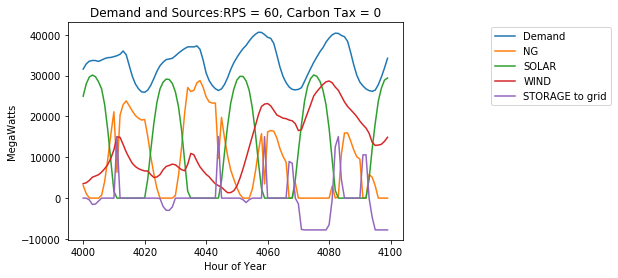

In [35]:
s = slice(4000,4100)
plot_sources(lp,s)
plot_storage(lp,s)

### Negative Storage_to_grid means storage is charging from grid.
### Positive Storage_to_grid means storage is powering grid

# Increase rps_percent to 90%.
### Storage may be needed for extremely high rps_percentages.

In [36]:
lp.rps_percent = 90
lp.solve()

True

In [37]:
source_stats(lp)

,capital,variable,co2_per_mwh,nameplate,generated,cost_of_money,carbon_tax,total_cost
NG,1239031.0,17.5,0.33,19479.701808,2.947029e+07,14.590721,0,3.166083e+10
SOLAR,1500000.0,0.0,0.00,81515.617946,1.967364e+08,14.590721,0,1.222734e+11
WIND,2051532.0,0.0,0.00,35925.384685,1.076173e+08,14.590721,0,7.370208e+10


In [38]:
storage_stats(lp)

,capital_charge,capital_storage,capital_discharge,storage_capacity,charge_capacity,discharge_capacity,total_cost
STORAGE,100000,187000,100000,256009.393329,35098.192808,33748.656431,5.475844e+10


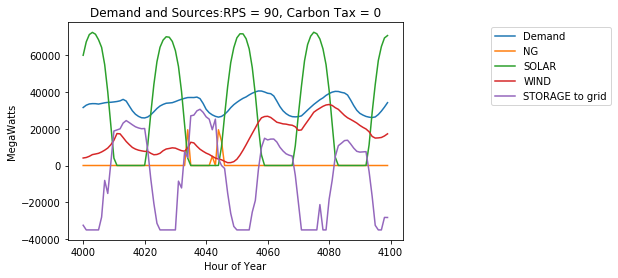

In [39]:
s = slice(4000,4100)
plot_sources(lp,s)
plot_storage(lp,s)